# Model

We will create a blank object, called `model`, to hold the various pieces of information we have about our model.

In [137]:
class Model:
    pass

model = Model()

## Source Demographics Data

We have some census data for Nigeria (2015) which we will use to set the initial populations for our nodes. Since we are modeling northern Nigeria, as a first cut we will only choose administrative districts which start with "NORTH_". That gives us 419 nodes with a total population of ~96M.

In [138]:
# setup initial populations
from pathlib import Path

import numpy as np
from nigeria import lgas

print(Path.cwd())
admin2 = {k:v for k,v in lgas.items() if len(k.split(":")) == 5}
print(f"{len(admin2)=}")

nn_nodes = {k:v for k, v in admin2.items() if k.split(":")[2].startswith("NORTH_")}
print(f"{len(nn_nodes)=}")

initial_populations = np.array([v[0][0] for v in nn_nodes.values()])
print(f"{len(initial_populations)=}")
print(f"First 32 populations:\n{initial_populations[0:32]}")
print(f"{initial_populations.sum()=:,}")

/Users/christopherlorton/projects/laser/nnmm
len(admin2)=774
len(nn_nodes)=419
len(initial_populations)=419
First 32 populations:
[218307 149264 156060 241059 449950 274092 187077 181261 325921 299948
 307508 238047 463961 131097 139646 140703 197673 213027 285194 108596
 247537 214049 209496  69858 963196 391221 212228 150535 116164 278727
 158456 319608]
initial_populations.sum()=96,171,118


## Parameters

We need some parameters now. We will use `PropertySet` rather than a raw dictionary for the "syntactic sugar" of referencing `params.ticks` rather than `params["ticks"]` each time.

Also, we will set the parameters separately as `meta_params` and `measles_params` but combine them into one parameter set for future use. We _could_ create `model.params = PropertySet({"meta":meta_params, "measles":measles_params})` and then reference them "by path" in the subsequent code, e.g., `params.meta.ticks` and `params.measles.inf_mean`.

In [139]:
from idmlaser.utils import PropertySet

meta_params = PropertySet({
    "ticks": 3650,
    "cbr": 40,  # Nigeria 2015 according to (somewhat random internet source): https://fred.stlouisfed.org/series/SPDYNCBRTINNGA
    "output": Path.cwd() / "outputs",
    "prng_seed": 20240801,
})

measles_params = PropertySet({
    "exp_mean": np.float32(7.0),
    "exp_std": np.float32(1.0),
    "inf_mean": np.float32(7.0),
    "inf_std": np.float32(1.0),
    "r_naught": np.float32(14.0),
    "seasonality_factor": np.float32(0.125),
    "seasonality_phase": np.float32(182),
    "ri_coverage": np.float32(0.75),
})

network_params = PropertySet({
    "a": np.float32(1.0),   # population 1 power factor
    "b": np.float32(1.0),   # population 2 power factor
    "c": np.float32(2.0),   # distance power factor
    "k": np.float32(137.0), # gravity constant
    "max_frac": np.float32(0.5), # maximum fraction of population that can move in a single tick
})

model.params = PropertySet(meta_params, measles_params, network_params) # type: ignore
model.params.beta = model.params.r_naught / model.params.inf_mean # type: ignore


## PRNG Seeding

**_Note 1:_** We will use the `default_rng` from `numpy.random` for the model PRNG and `np.random` for the Numba PRNG (Numba rewrites np.random to its parallelized PRNG).

**_Note 2:_** PRNG seeding for reproducibility depends on using the same number of cores (or enforced with `nb.set_num_threads()` or setting the `NUMBA_NUM_THREADS` environment variable?).

In [140]:
import numba as nb

@nb.njit(parallel=True)
def set_numba_seeds(seed: np.uint32):

    for t in nb.prange(nb.get_num_threads()):
        np.random.seed(seed + t)

    return

print(f"Setting the model PRNG and Numba PRNG seeds for {nb.get_num_threads()} threads using seed {model.params.prng_seed}")
model.prng = np.random.default_rng(np.uint32(model.params.prng_seed))
set_numba_seeds(np.uint32(model.prng.integers(0, 2**32)))

Setting the model PRNG and Numba PRNG seeds for 10 threads using seed 20240801


## Capacity Calculation

We have our initial populations, but we need to allocate enough space to handle growth during the simulation.

In [141]:
from idmlaser.numpynumba import Population

capacity = initial_populations.sum()
print(f"initial {capacity=:,}")
print(f"{model.params.cbr=}, {model.params.ticks=}")    # type: ignore
growth = ((1.0 + model.params.cbr/1000)**(model.params.ticks // 365))   # type: ignore
print(f"{growth=}")
capacity *= growth
capacity *= 1.01  # 1% buffer
capacity = np.uint32(np.round(capacity))
print(f"required {capacity=:,}")
print(f"Allocating capacity for {capacity:,} individuals")
population = Population(capacity)
model.population = population   # type: ignore
ifirst, ilast = population.add(initial_populations.sum())
print(f"{ifirst=:,}, {ilast=:,}")

initial capacity=96,171,118
model.params.cbr=40, model.params.ticks=3650
growth=1.4802442849183444
required capacity=143,780,315
Allocating capacity for 143,780,315 individuals
ifirst=0, ilast=96,171,118


## Node IDs

Add a property for node id. 419 nodes requires 9 bits so we will allocate a 16 bit value. Negative IDs don't make sense, so, `uint16`.

In [142]:
population.add_scalar_property("nodeid", np.uint16)
index = 0
for nodeid, count in enumerate(initial_populations):
    population.nodeid[index:index+count] = nodeid
    index += count

print(f"Sample node IDs: {','.join([str(model.population.nodeid[i]) for i in range(0, initial_populations.sum(), initial_populations.sum() // 32)])}")


Sample node IDs: 0,11,24,37,52,68,83,99,111,125,141,151,162,178,191,204,220,237,251,263,271,282,292,302,313,323,337,350,365,381,395,409,418


## Node Populations

We will need the most recent population numbers in order to determine the births, based on CBR, for the upcoming year. We will also, later, use the current population to determine the effective force of infection, i.e., total contagion / node population.

Default data type is uint32.

In [143]:
node_count = len(nn_nodes)
nodes = Population(capacity=node_count) # TODO: rename `Population` to some appropriate to agents _and_ nodes
model.nodes = nodes # type: ignore
ifirst, ilast = nodes.add(node_count)
print(f"{ifirst=:,}, {ilast=:,}")
nodes.add_vector_property("population", model.params.ticks + 1) # type: ignore
nodes.population[:,0] = initial_populations


ifirst=0, ilast=419


## RI Coverages

In [144]:
# Add new property "ri_coverages"
nodes.add_scalar_property("ri_coverages", dtype=np.float32)
nodes.ri_coverages = model.prng.random(node_count)

print(f"RI coverage in first 32 nodes {model.nodes.ri_coverages[0:32]=}")

RI coverage in first 32 nodes model.nodes.ri_coverages[0:32]=array([0.47622274, 0.22036155, 0.98522527, 0.13700373, 0.97852928,
       0.16953883, 0.27912942, 0.21064626, 0.12834709, 0.92700596,
       0.71294196, 0.05859837, 0.62728704, 0.61403882, 0.40116459,
       0.09390595, 0.67710003, 0.0691091 , 0.99095782, 0.78455779,
       0.32208822, 0.47586861, 0.1402482 , 0.72634368, 0.31229709,
       0.13171976, 0.35911209, 0.49347889, 0.82234353, 0.84898541,
       0.09350133, 0.7175923 ])


## Population per Tick

We will propagate the current populations forward on each tick. Vital dynamics of births and non-disease deaths will update the current values. The argument signature for per tick step phases is (`model`, `tick`). This lets functions access model specific properties and use the current tick, if necessary, e.g. record information or decide to act.

In [145]:
def propagate_population(model, tick):
    model.nodes.population[:,tick+1] = model.nodes.population[:,tick]

    return


## Vital Dynamics: Births

Let's implement births over time. We will use the CBR in `model.params` and draw for the number of births this year based on the most recent population. Then, we will distribute those births as evenly as possible for integral values over the days of the year.

Note that we add in the date of birth and date of non-disease death after we add those properties below.

Note that we add in initializing the susceptibility after we add that property below.

In [146]:
from idmlaser.kmcurve import pdsod

model.nodes.add_vector_property("births", (model.params.ticks + 364) // 365)    # births per year

# Adding ri_timer here since it's referred to in do_births.
model.population.add_scalar_property("ri_timer", np.uint16)

def do_births(model, tick):

    doy = tick % 365 + 1    # day of year 1...365
    year = tick // 365

    if doy == 1:
        model.nodes.births[:, year] = model.prng.poisson(model.nodes.population[:, tick] * model.params.cbr / 1000)

    annual_births = model.nodes.births[:, year]
    todays_births = (annual_births * doy // 365) - (annual_births * (doy - 1) // 365)
    count_births = todays_births.sum()
    istart, iend = model.population.add(count_births)   # add count_births agents to the population, get the indices of the new agents

    # enable this after loading the aliased distribution and dod and dob properties (see cells below)
    model.population.dod[istart:iend] = tick + pdsod(model.population.dob[istart:iend], max_year=100, prng=model.prng)   # make use of the fact that dob[istart:iend] is currently 0
    model.population.dob[istart:iend] = tick    # now update dob to reflect being born today

    # enable this after adding susceptibility property to the population (see cells below)
    model.population.susceptibility[istart:iend] = 1

    index = istart
    nodeids = model.population.nodeid   # grab this once for efficiency
    dods = model.population.dod # grab this once for efficiency
    max_tick = model.params.ticks
    for nodeid, births in enumerate(todays_births):
        nodeids[index:index+births] = nodeid
        for agent in range(index, index+births):
            # If the agent will die before the end of the simulation, add it to the queue
            if dods[agent] < max_tick:
                model.nddq.push(agent)
        index += births
    model.nodes.population[:,tick+1] += todays_births

    # Draw RI timer values for newborns
    # TODO: Change or parameterize as appropriate
    ri_timer_values = model.prng.uniform(8.5 * 30.5, 9.5 * 30.5, count_births).astype(np.uint16)

    # ri_timer is initialized to 0, we will just set the values for selected (fortunate) agents, based on their node RI coverage
    assert count_births == (iend - istart)
    mask = model.prng.random(count_births) < (model.nodes.ri_coverages[model.population.nodeid[istart:iend]])
    model.population.ri_timer[istart:iend][mask] = ri_timer_values[mask]

    return



# Non-Disease Mortality

## Non-Disease Mortality Part I

We start by loading a population pyramid in order to initialize the ages of the initial population realistically.

The population pyramid is typically in 5 year age buckets. Once we draw for the age bucket, we draw uniformly for a date of birth within the range of the bucket.

**Note:** the values in `model.population.dob` are _positive_ at this point. Later we will negate them to convert them to dates of birth prior to now (t = 0).

In [147]:
from tqdm import tqdm

import idmlaser.pyramid as pyramid

pyramid_file = Path.cwd().parent / "tests" / "USA-pyramid-2023.csv"
print(f"Loading pyramid from '{pyramid_file}'...")
age_distribution = pyramid.load_pyramid_csv(pyramid_file)
print("Creating aliased distribution...")
aliased_distribution = pyramid.AliasedDistribution(age_distribution[:,4], prng=model.prng)
count_active = initial_populations.sum()
print(f"Sampling {count_active:,} ages... {model.population.count=:,}")
buckets = aliased_distribution.sample(model.population.count)
print(f"First 32 buckets:\n{buckets[:32]}")
minimum_age = age_distribution[:, 0] * 365      # closed, include this value
limit_age = (age_distribution[:, 1] + 1) * 365  # open, exclude this value
model.population.add_scalar_property("dob", np.int32)
mask = np.zeros(capacity, dtype=bool)

print("Converting age buckets to ages...")
for i in tqdm(range(len(age_distribution))):
    mask[:count_active] = (buckets == i)    # indices of agents in this age group bucket
    # draw uniformly between the start and end of the age group bucket
    model.population.dob[mask] = model.prng.integers(low=minimum_age[i], high=limit_age[i], size=mask.sum())

print(f"First 32 ages:\n{model.population.dob[0:32]=}")

Loading pyramid from '/Users/christopherlorton/projects/laser/tests/USA-pyramid-2023.csv'...
Reading data from '/Users/christopherlorton/projects/laser/tests/USA-pyramid-2023.csv' ...
Creating aliased distribution...
Sampling 96,171,118 ages... model.population.count=96,171,118
First 32 buckets:
[13  4  9  7  9 11  4  3  2  8 18  0  3  3 10  4 12 11  5  6 12  5  7  4
  9  4  5 10 10  3 14  3]
Converting age buckets to ages...


100%|██████████| 21/21 [00:03<00:00,  6.64it/s]

First 32 ages:
model.population.dob[0:32]=array([24793,  8123, 17843, 13140, 17949, 21437,  8676,  6989,  3929,
       16054, 34376,  1522,  7117,  6713, 18982,  8760, 22848, 21289,
       10448, 11628, 23396,  9423, 13282,  8072, 16567,  7584,  9490,
       19311, 19599,  6041, 26381,  6289], dtype=int32)


## Non-Disease Mortality Part II

We import `pdsod` ("predicted_days_of_death") which currently uses a USA 2003 survival table. `pdsod` will draw for a year of death (in or after the current age year) and then will draw a day in the selected year.

**Note:** the incoming values in `model.population.dob` are positive (_ages_). After we use them to draw for date of death, we negate them to convert them to dates of birth (in days) prior to now (t=0).

In [148]:
from datetime import datetime

from idmlaser.kmcurve import pdsod  # noqa: F811

population.add_scalar_property("dod", np.int32)
dobs = population.dob
dods = population.dod
tstart = datetime.now(tz=None)  # noqa: DTZ005
dods[0:population.count] = pdsod(dobs[0:population.count], max_year=100, prng=model.prng)
tfinish = datetime.now(tz=None)  # noqa: DTZ005
print(f"Elapsed time for drawing dates of death: {tfinish - tstart}")

dods -= dobs.astype(dods.dtype) # renormalize to be relative to _now_ (t = 0)
dobs *= -1  # convert ages to date of birth prior to _now_ (t = 0) ∴ negative
print(f"First 32 DoBs (should all be negative - these agents were born before today):\n{dobs[:32]}")
print(f"First 32 DoDs (should all be positive - these agents will all pass in the future):\n{dods[:32]}")

Elapsed time for drawing dates of death: 0:00:00.772621
First 32 DoBs (should all be negative - these agents were born before today):
[-24793  -8123 -17843 -13140 -17949 -21437  -8676  -6989  -3929 -16054
 -34376  -1522  -7117  -6713 -18982  -8760 -22848 -21289 -10448 -11628
 -23396  -9423 -13282  -8072 -16567  -7584  -9490 -19311 -19599  -6041
 -26381  -6289]
First 32 DoDs (should all be positive - these agents will all pass in the future):
[ 7431 19252 14639 13184  7013  7952 21086 21649 25906 17913  1786 23510
 28548 11616 16482 14901 10930  9544 22143 19628  2659 25155 12796 22069
 13828 20078 24615  4231  3735 18944  6845 16385]


## Non-Disease Mortality Part III

If we had no births, we could use a regular FIFO queue with the dates of death sorted to process non-disease deaths in time order. However, we may have agents born during the simulation who are predicted to die from non-disease causes before the end of the simulation and need to be insert, in sorted order, into the queue. So, we will use a priority queue - a data structure which allows for efficient insertion and removal while maintaining sorted order - to keep track of agents by date of non-disease death.

In [149]:
from idmlaser.utils import PriorityQueuePy

tstart = datetime.now(tz=None)  # noqa: DTZ005
dods = population.dod
mortality = PriorityQueuePy(capacity, dods)
for i in tqdm(indices := np.nonzero(dods[0:population.count] < model.params.ticks)[0]):
    mortality.push(i)
tfinish = datetime.now(tz=None)  # noqa: DTZ005

print(f"Elapsed time for pushing dates of death: {tfinish - tstart}")
print(f"Non-disease mortality: tracked {len(indices):,}, untracked {population.count - len(indices):,}")

model.nddq = mortality

100%|██████████| 11174620/11174620 [00:08<00:00, 1356080.50it/s]

Elapsed time for pushing dates of death: 0:00:08.334579
Non-disease mortality: tracked 11,174,620, untracked 84,996,498


## Non-Disease Mortality Part IV

During the simulation, we will process all agents with a predicated date of death today marking them as deceased and removing them from the active population count.

**_TODO:_** Set a state to indicate "deceased" _or_ ignore the priority queue altogether and compare `dod` against `tick` and ignore agents where `dod < tick`.

In [150]:
model.nodes.add_vector_property("deaths", (model.params.ticks + 364) // 365)    # deaths per year

def do_non_disease_deaths(model, tick):

    nodeids = model.population.nodeid
    node_population = model.nodes.population[:, tick+1]
    year = tick // 365
    node_deaths = model.nodes.deaths[:, year]
    susceptibility = model.population.susceptibility

    pq = model.nddq
    while len(pq) > 0 and pq.peekv() <= tick:
        i = pq.popi()
        nodeid = nodeids[i]
        node_population[nodeid] -= 1
        node_deaths[nodeid] += 1
        susceptibility[i] = 0   # disqualifies from infection etc.

    return

## Incubation and Infection

We will add incubation timer (`etimer` for "exposure timer") and an infection (or infectious) timer (`itimer`) properties to the model population. A `uint8` counting down from as much as 255 days will be more than enough.

We wrap a Numba compiled function using all available cores in the infection update function, extracting the `count` and `itimer` values the JITted function needs.

Similarly, we wrap a Numba compiled function using all available cores in the exposure update function, extracting the values the JITted function needs from the `model` object.

In [151]:
import numba as nb

model.population.add_scalar_property("etimer", np.uint8)
model.population.add_scalar_property("itimer", np.uint8)

@nb.njit((nb.uint32, nb.uint8[:]), parallel=True)
def _infection_update(count, itimers):
    for i in nb.prange(count):
        if itimers[i] > 0:
            itimers[i] -= 1

    return

def do_infection_update(model, tick):

    _infection_update(nb.uint32(model.population.count), model.population.itimer)

    return

@nb.njit((nb.uint32, nb.uint8[:], nb.uint8[:], nb.float32, nb.float32), parallel=True)
def _exposure_update(count, etimers, itimers, inf_mean, inf_std):
    for i in nb.prange(count):
        if etimers[i] > 0:
            etimers[i] -= 1
            if etimers[i] == 0:
                itimers[i] = np.maximum(np.uint8(1), np.uint8(np.round(np.random.normal(inf_mean, inf_std))))    # must be at least 1 day

    return

def do_exposure_update(model, tick):

    _exposure_update(nb.uint32(model.population.count), model.population.etimer, model.population.itimer, model.params.inf_mean, model.params.inf_std)

    return

## Susceptibility

We add a `susceptibility` property to the population in order to identify susceptible agents.

Maternal immunity, once implemented, will mean setting `susceptibility = 0` at birth and then setting `susceptibility = 1` at some point in the future when maternal antibodies have been determined to have waned.

RI, once implemented, will set `susceptibility = 0` if the infant is determined to get an efficacious innoculation. The infant might _not_ get an innoculation depending on RI coverage in their home node. Also, an RI innoculation might not be efficacious due to interference by maternal antibodies or just by vaccine failure.

Transmission, once implemented, will set `susceptibility = 0` so the agent is not considered for future transmission. I.e., agents in the exposed, infectious, recovered, or deceased state should have `susceptibility` set to 0.

**Note:** We initialize `susceptibility` to 0 since the majority of the initial population will have already been exposed to measles or have been vaccinated. First cut here is to set all agents under age 5 as susceptible.

**_TODO:_** Update this function to consider maternal immunity. Children under 1(?) year of age should draw for a date of maternal immunity waning. If they are _under_ that age, their susceptibility should be set to `0` and they should be put in a priority queue based on waning date to have their susceptibility set to `1`.

**_TODO:_** Update this function to probabilistically set susceptibility to `0` for children over 1 year of age based on local RI coverage and other factors (estimated prevalence and probability of _not_ having had measles?).

In [152]:
model.population.add_scalar_property("susceptibility", np.uint8)

# initialize susceptibility based on age
@nb.njit((nb.uint32, nb.int32[:], nb.uint8[:]), parallel=True)
def initialize_susceptibility(count, dob, susceptibility):

    for i in nb.prange(count):
        if dob[i] >= -365*5:
            susceptibility[i] = 1

    return

initialize_susceptibility(model.population.count, model.population.dob, model.population.susceptibility)

## Routine Immunization - RI

- Children under 1(?) year of age should draw for a date of RI (consider whether to draw vs. RI coverage in the node before choosing an RI date or later when their RI date comes up). Children with an RI date in the future should be put in a priority queue to be processed on their date of RI.
  - There can be a single `riq` for the model, there is no need to differentiate by node (any node heterogeneity can be considered when their RI date comes up).

- Create a tick/step phase function to process all agents with RI due on the given tick (see do_non_disease_deaths). This function draws to determine if the innoculation happens (based on RI coverage if the draw is not done at birth), determines if the innoculation is efficacious (potential maternal immunity interference or just vaccine failure). If the vaccination does not take, the agent should be considered for a follow-up RI at 15 months which would be in an additional RI priority queue.

- Update do_births to draw for RI (based on coverage) and RI date (based on RI date distribution) and put them into the `model.riq` (or set an RI timer...).

In [153]:
# Define the function to decrement ri_timer and update susceptibility
@nb.njit((nb.uint32, nb.uint16[:], nb.uint8[:]), parallel=True)
def _update_susceptibility_based_on_ri_timer(count, ri_timer, susceptibility):
    for i in nb.prange(count):
        if ri_timer[i] > 0:
            ri_timer[i] -= 1
            # TBD: It's perfectly possible that the individual got infected (or recovered) while this timer
            # was counting down and we might want to abort the timer.
            if ri_timer[i] == 0:
                susceptibility[i] = 0

# Example usage
#update_susceptibility_based_on_ri_timer(model.population.count, model.population.ri_timer, model.population.susceptibility)

def do_ri(model, tick):
    _update_susceptibility_based_on_ri_timer(model.population.count, model.population.ri_timer, model.population.susceptibility)
    return


## Initial Infections

We choose up to 10 infections per node initially. Another option would be to choose the initial number of infections based on estimated prevalence.

**Note:** this function has a known bug based on using Numba to optimize the function. [Numba only exposes an atomic decrement in CUDA implementations](https://numba.readthedocs.io/en/stable/cuda/intrinsics.html) so on the CPU it is possible that more than one thread decides there are still agents to initialize as infected and the total count of initial infections is more than specified.

**_TODO:_** After checking to see if there are still infections to be initialized in this node, consider checking the susceptibility of the agent as well, i.e., only infect susceptible agents.

**_TODO_:** Fix this with a compiled C/C++ function and [OpenMP 'atomic update'](https://www.openmp.org/spec-html/5.0/openmpsu95.html).

In [154]:
# initial_infections = model.prng.integers(0, 11, size=model.nodes.count, dtype=np.uint32)
prevalence = 0.025 # 2.5% prevalence
initial_infections = np.uint32(np.round(model.prng.poisson(prevalence*initial_populations)))
print(f"Initial infections for first 32 nodes:\n{initial_infections[:32]=}")

@nb.njit((nb.uint32, nb.uint32[:], nb.uint16[:], nb.uint8[:], nb.float32, nb.float32), parallel=True)
def initialize_infections(count, infections, nodeid, itimer, inf_mean, inf_std):

    for i in nb.prange(count):
        if infections[nodeid[i]] > 0:
            infections[nodeid[i]] -= 1
            itimer[i] = np.maximum(np.uint8(1), np.uint8(np.round(np.random.normal(inf_mean, inf_std)))) # must be at least 1 day

    return

# Print this _before_ initializing infections because `initial_infections` is modified in-place.
print(f"{initial_infections.sum()=:,}")

initialize_infections(np.uint32(model.population.count), initial_infections, model.population.nodeid, model.population.itimer, model.params.inf_mean, model.params.inf_std)

print(f"{(model.population.itimer > 0).sum()=:,}")

Initial infections for first 32 nodes:
initial_infections[:32]=array([ 5453,  3706,  3909,  5970, 11374,  6812,  4668,  4594,  8067,
        7500,  7728,  5920, 11665,  3190,  3490,  3474,  4873,  5352,
        7082,  2715,  6201,  5446,  5322,  1784, 24116,  9816,  5316,
        3799,  2873,  7005,  4001,  7772], dtype=uint32)
initial_infections.sum()=2,406,962
(model.population.itimer > 0).sum()=2,406,962


# Transmission

## Transmission Part I - Setup

We will add a `network` property to the model to hold the connection weights between the nodes.

We initialize $n_{ij} = n_{ji} = k \frac {P_i^a \cdot P_j^b} {D_{ij}^c}$

Then we limit outgoing migration from any one node to `max_frac`.

In [155]:
# We need to calculate the distances between the centroids of the nodes in northern Nigeria
model.nodes.add_vector_property("network", model.nodes.count, dtype=np.float32)
network = model.nodes.network

RE = 6371.0  # Earth radius in km

def calc_distance(lat1, lon1, lat2, lon2):
    # convert to radians
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)
    # haversine formula (https://en.wikipedia.org/wiki/Haversine_formula)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    d = RE * c
    return d

locations = np.zeros((model.nodes.count, 2), dtype=np.float32)
for i, node in enumerate(nn_nodes.values()):
    (longitude, latitude) = node[1]
    locations[i, 0] = latitude
    locations[i, 1] = longitude
locations = np.radians(locations)

# TODO: Consider keeping the distances and periodically recalculating the network values as the populations change
a = model.params.a
b = model.params.b
c = model.params.c
k = model.params.k
for i in tqdm(range(model.nodes.count)):
    popi = initial_populations[i]
    for j in range(i+1, model.nodes.count):
        popj = initial_populations[j]
        network[i,j] = network[j,i] = k * (popi**a) * (popj**b) / (calc_distance(*locations[i], *locations[j])**c)
network /= np.power(initial_populations.sum(), c)    # normalize by total population^2

print(f"Upper left corner of network looks like this (before limiting to max_frac):\n{network[:4,:4]}")

max_frac = model.params.max_frac
for row in range(network.shape[0]):
    if (maximum := network[row].sum()) > max_frac:
        network[row] *= max_frac / maximum

print(f"Upper left corner of network looks like this (after limiting to max_frac):\n{network[:4,:4]}")

100%|██████████| 419/419 [00:00<00:00, 496.73it/s]

Upper left corner of network looks like this (before limiting to max_frac):
[[0.00000000e+00 1.13174756e-04 2.06039316e-04 1.19610282e-04]
 [1.13174756e-04 0.00000000e+00 1.36084005e-03 7.34199421e-05]
 [2.06039316e-04 1.36084005e-03 0.00000000e+00 8.51625373e-05]
 [1.19610282e-04 7.34199421e-05 8.51625373e-05 0.00000000e+00]]
Upper left corner of network looks like this (after limiting to max_frac):
[[0.00000000e+00 1.13174756e-04 2.06039316e-04 1.19610282e-04]
 [1.13174756e-04 0.00000000e+00 1.36084005e-03 7.34199421e-05]
 [2.06039316e-04 1.36084005e-03 0.00000000e+00 8.51625373e-05]
 [1.19610282e-04 7.34199421e-05 8.51625373e-05 0.00000000e+00]]


## Transmission Part II - Tick/Step Processing Phase

On a tick we accumulate the contagion in each node - currently 1 unit per infectious agent - with `np.add.at()` ([documentation](https://numpy.org/doc/stable/reference/generated/numpy.ufunc.at.html)).

We calculate the incoming and outgoing contagion by multiplying by the network connection values.

We determine the force of infection per agent in each node by multiplying by the seasonally adjusted $\beta$ and normalizing by the node population. $\beta_{eff}$ is currently a scalar but it would be trivial to add a `beta` property to `model.nodes` and have per node betas.

We then visit each susceptible agent and draw against the force of infection to determine transmission and draw for duration of infection if transmission occurs.

We will also track incidence by node and tick.

In [156]:
@nb.njit(
    (nb.uint8[:], nb.uint16[:], nb.float32[:], nb.uint8[:], nb.uint32, nb.float32, nb.float32, nb.uint32[:]),
    parallel=True,
    nogil=True,
    cache=True,
)
def tx_inner(susceptibilities, nodeids, forces, etimers, count, exp_mean, exp_std, incidence):
    for i in nb.prange(count):
        susceptibility = susceptibilities[i]
        if susceptibility > 0:
            nodeid = nodeids[i]
            force = susceptibility * forces[nodeid] # force of infection attenuated by personal susceptibility
            if (force > 0) and (np.random.random_sample() < force):  # draw random number < force means infection
                susceptibilities[i] = 0.0  # set susceptibility to 0.0
                # set exposure timer for newly infected individuals to a draw from a normal distribution, must be at least 1 day
                etimers[i] = np.maximum(np.uint8(1), np.uint8(np.round(np.random.normal(exp_mean, exp_std))))
                incidence[nodeid] += 1

    return

model.nodes.add_vector_property("cases", model.params.ticks, dtype=np.uint32)
model.nodes.add_scalar_property("forces", dtype=np.float32)
model.nodes.add_vector_property("incidence", model.params.ticks, dtype=np.uint32)

def do_transmission_update(model, tick) -> None:

    nodes = model.nodes
    population = model.population

    contagion = nodes.cases[:, tick]    # we will accumulate current infections into this array
    nodeids = population.nodeid[:population.count]  # just look at the active agent indices
    itimers = population.itimer[:population.count] # just look at the active agent indices
    np.add.at(contagion, nodeids[itimers > 0], 1)   # increment by the number of active agents with non-zero itimer

    network = nodes.network
    transfer = (contagion * network).round().astype(np.uint32)
    contagion += transfer.sum(axis=1)   # increment by incoming "migration"
    contagion -= transfer.sum(axis=0)   # decrement by outgoing "migration"

    forces = nodes.forces
    beta_effective = model.params.beta + model.params.seasonality_factor * np.sin(2 * np.pi * (tick - model.params.seasonality_phase) / 365)
    np.multiply(contagion, beta_effective, out=forces)
    np.divide(forces, model.nodes.population[:, tick], out=forces)  # per agent force of infection

    tx_inner(
        population.susceptibility,
        population.nodeid,
        forces,
        population.etimer,
        population.count,
        model.params.exp_mean,
        model.params.exp_std,
        model.nodes.incidence[:, tick],
    )

    return


## Interventions : Serosurveys and SIAs

Let's try an SIA 10 days into the simulation.

_Consider sorting the SIAs by tick in order to be able to just check the first N campaigns in the list._


In [157]:
from collections import namedtuple

SEROSURVEY = namedtuple("SEROSURVEY", ["tick", "nodes", "age_days_min", "age_days_max"])
SIA = namedtuple("SIA", ["tick", "nodes", "coverage", "age_days_min", "age_days_max"])
EDUCATION = namedtuple("EDUCATION", ["tick", "nodes"])

NINE_MONTHS = 274   # 9 months in days (30 day months + 9/12 of the 5 addition days in a year)
SIX_YEARS = 6 * 365 # 6 years in days

todo = [
    SEROSURVEY(9, [0, 1, 2, 3, 4, 5], NINE_MONTHS, SIX_YEARS),  # Tick 9, nodes 0-5, [2-6) years old
    SIA(10, [1, 3, 5], 0.80, NINE_MONTHS, SIX_YEARS), # Tick 10, nodes 1, 3, and 5, 80% coverage, [2-6) years old
    SEROSURVEY(11, [0, 1, 2, 3, 4, 5], NINE_MONTHS, SIX_YEARS),  # Tick 11, nodes 0-5, [2-6) years old
    EDUCATION(30, [0, 1, 2, 3, 4, 5]),  # Tick 30, nodes 0-5
    ]

model.nodes.add_vector_property("seronegativity", model.params.ticks, dtype=np.uint32)

@nb.njit((nb.uint32, nb.uint16[:], nb.uint16[:], nb.uint8[:], nb.uint32[:]), parallel=True)
def _do_serosurvey(count, targets, nodeids, susceptibilities, seronegativity):
    for i in nb.prange(count):
        if targets[nodeids[i]]:
            if susceptibilities[i] > 0:
                seronegativity[nodeids[i]] += 1

    return

def invoke_serosurvey(campaign, model, tick):
    print(f"Running serosurvey {campaign=} at tick {tick}")
    targets = np.zeros(model.nodes.count, dtype=np.uint16)
    targets[campaign.nodes] = 1
    _do_serosurvey(
        model.population.count,
        targets,
        model.population.nodeid,
        model.population.susceptibility,
        model.nodes.seronegativity[:, tick],
        )

    return

@nb.njit((nb.uint32, nb.uint16[:], nb.uint16[:], nb.uint8[:], nb.float32, nb.int32[:], nb.int32, nb.int32, nb.int32), parallel=True)
def _do_sia(count, targets, nodeids, susceptibilities, coverage, dobs, age_min, age_max, tick):
    for i in nb.prange(count):
        if targets[nodeids[i]]:
            age = tick - dobs[i]
            if (age_min <= age) and (age < age_max):
                if susceptibilities[i] > 0:
                    if np.random.random_sample() < coverage:
                        susceptibilities[i] = 0

    return

def invoke_sia(campaign, model, tick):
    print(f"Running SIA {campaign=} at tick {tick}")
    targets = np.zeros(model.nodes.count, dtype=np.uint16)
    targets[campaign.nodes] = 1
    _do_sia(
        model.population.count,
        targets,
        model.population.nodeid,
        model.population.susceptibility,
        np.float32(campaign.coverage),
        model.population.dob,
        np.int32(campaign.age_days_min),
        np.int32(campaign.age_days_max),
        np.int32(tick),
        )

    return

iv_map = {
    SEROSURVEY: invoke_serosurvey,
    SIA: invoke_sia,
    EDUCATION: lambda campaign, model, tick: print(f"Running education {campaign=} at tick {tick}"),
}

def do_interventions(model, tick):
    while len(todo) > 0 and todo[0][0] == tick:
        campaign = todo.pop(0)
        iv_map[type(campaign)](campaign, model, tick)

for iv in todo:
    if not type(iv) in iv_map:
        raise ValueError(f"Missing invoke function for intervention type: {type(iv).__name__}")


## Tick/Step Processing Phases

The phases (sub-steps) of the processing on each tick go here as they are implemented.

In [158]:
# consider `step_functions` rather than `phases` for the following
model.phases = [
    propagate_population,
    do_births, # type: ignore
    do_non_disease_deaths, # type: ignore
    do_infection_update, # type: ignore
    do_exposure_update, # type: ignore
    do_transmission_update, # type: ignore
    do_ri, # type: ignore
    do_interventions, # type: ignore
]


# **Running the Simulation**

We iterate over the specified number of ticks, keeping track, in `metrics`, of the time spent in each phase at each tick.

In [159]:
from datetime import datetime

from tqdm import tqdm

model.metrics = []
for tick in tqdm(range(model.params.ticks)):
    metrics = [tick]
    for phase in model.phases:
        tstart = datetime.now(tz=None)  # noqa: DTZ005
        phase(model, tick)
        tfinish = datetime.now(tz=None)  # noqa: DTZ005
        delta = tfinish - tstart
        metrics.append(delta.seconds * 1_000_000 + delta.microseconds)  # delta is a timedelta object, let's convert it to microseconds
    model.metrics.append(metrics)


  0%|          | 11/3650 [00:02<11:07,  5.45it/s]

Running serosurvey campaign=SEROSURVEY(tick=9, nodes=[0, 1, 2, 3, 4, 5], age_days_min=274, age_days_max=2190) at tick 9
Running SIA campaign=SIA(tick=10, nodes=[1, 3, 5], coverage=0.8, age_days_min=274, age_days_max=2190) at tick 10


  0%|          | 13/3650 [00:02<11:20,  5.35it/s]

Running serosurvey campaign=SEROSURVEY(tick=11, nodes=[0, 1, 2, 3, 4, 5], age_days_min=274, age_days_max=2190) at tick 11


  1%|          | 32/3650 [00:05<08:12,  7.35it/s]

Running education campaign=EDUCATION(tick=30, nodes=[0, 1, 2, 3, 4, 5]) at tick 30


100%|██████████| 3650/3650 [06:31<00:00,  9.32it/s]


# Post-Simulation Analysis

## Final Population

Let's take a quick look at the final population size accounting for births over the course of the simulation. This does _not_ account for non-disease deaths so we are looking at the maximum number of unique agents over the simulation.

In [160]:
print(f"{model.population.count=:,} (vs. requested capacity {model.population.capacity=:,})")

model.population.count=140,003,538 (vs. requested capacity model.population.capacity=143,780,315)


## Timing Metrics Part I

Let's convert the timing information to a DataFrame and peek at the first few entries.

In [161]:
import pandas as pd

metrics = pd.DataFrame(model.metrics, columns=["tick"] + [phase.__name__ for phase in model.phases])
metrics.head()

,tick,propagate_population,do_births,do_non_disease_deaths,do_infection_update,do_exposure_update,do_transmission_update,do_ri,do_interventions
0,0,1150,8404,7,5176,6315,134199,21661,4
1,1,20,9007,109523,5256,5915,129097,5761,5
2,2,13,8587,80666,6440,7270,129502,5221,5
3,3,15,9191,72186,5270,6205,126784,5645,4
4,4,21,9232,69137,5430,6989,123353,6321,3


## Timing Metrics Part II

Let's take a look at where we spend our processing time.

propagate_population          97095
do_births                  36454596
do_non_disease_deaths      67862537
do_infection_update        24677245
do_exposure_update         25108112
do_transmission_update    191096045
do_ri                      44904833
do_interventions              40677
dtype: int64
Total:                390,241,140


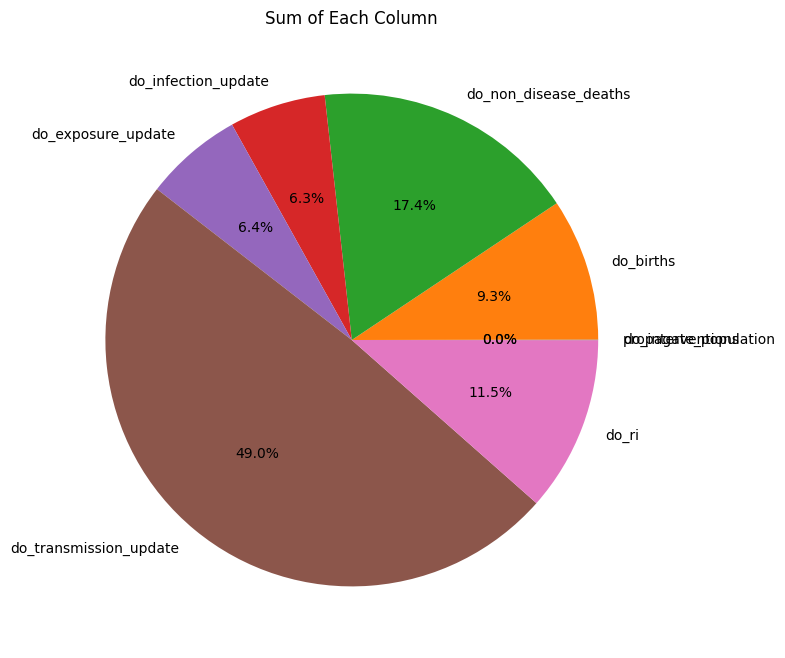

In [162]:
import matplotlib.pyplot as plt

plot_columns = metrics.columns[1:]
sum_columns = metrics[plot_columns].sum()
print(sum_columns)
print("=" * 33)
print(f"Total: {sum_columns.sum():26,}")
plt.figure(figsize=(8, 8))
plt.pie(sum_columns, labels=sum_columns.index, autopct="%1.1f%%")
plt.title("Sum of Each Column")
plt.show()

## Validation - Population Over Time

Let's make sure that our population is growing over time by plotting the population for a few nodes.

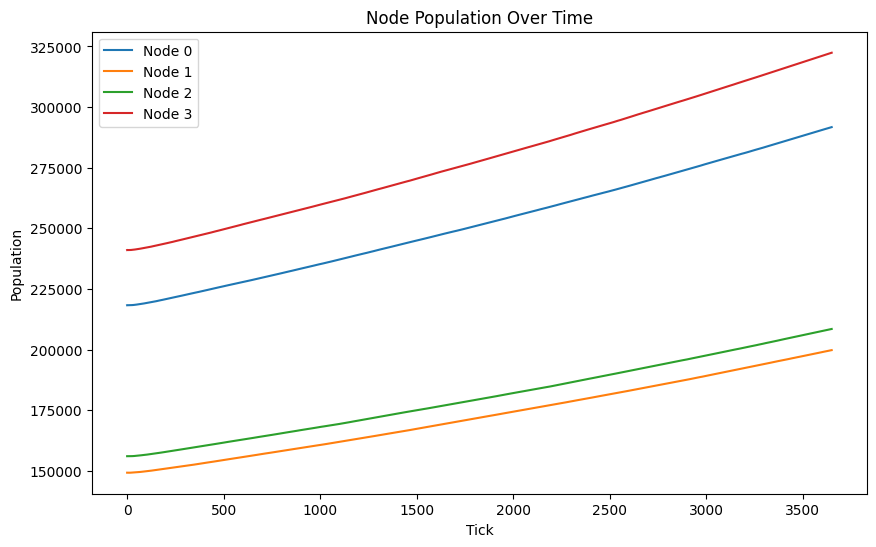

In [163]:
from matplotlib import pyplot as plt

nodes_to_plot = [0, 1, 2, 3]
node_population = model.nodes.population[nodes_to_plot, :]

plt.figure(figsize=(10, 6))
for i, node in enumerate(nodes_to_plot):
    plt.plot(range(model.params.ticks + 1), node_population[i, :], label=f"Node {node}")

plt.xlabel("Tick")
plt.ylabel("Population")
plt.title("Node Population Over Time")
plt.legend()
plt.show()

## Validation - Births

Let's see if our births over time look right. Given a fixed CBR and a growing population, we should generally have more births later in the simulation.

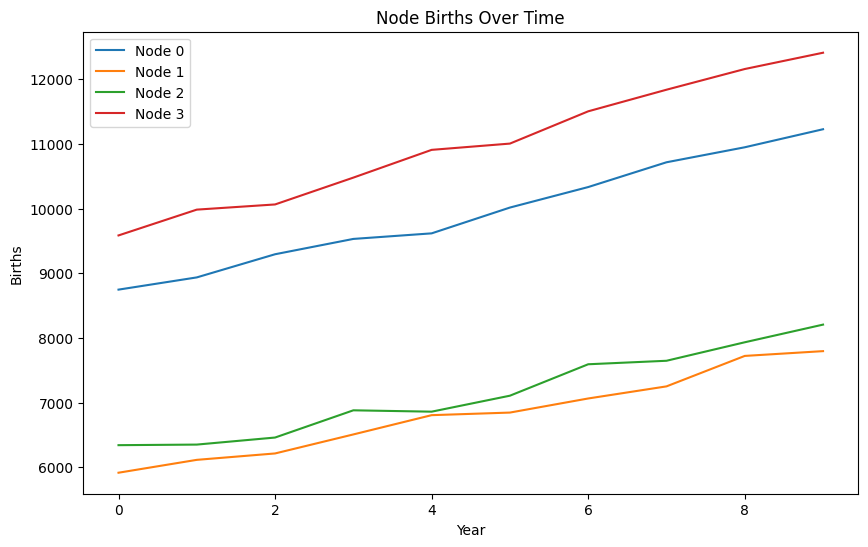

In [164]:
from matplotlib import pyplot as plt

node_births = model.nodes.births[nodes_to_plot, :]

plt.figure(figsize=(10, 6))
for i, node in enumerate(nodes_to_plot):
    plt.plot(range((model.params.ticks + 364) // 365), node_births[i, :], label=f"Node {node}")

plt.xlabel("Year")
plt.ylabel("Births")
plt.title("Node Births Over Time")
plt.legend()
plt.show()

## Validation - Non-Disease Deaths

Let's see if our non-disease deaths look right over time.

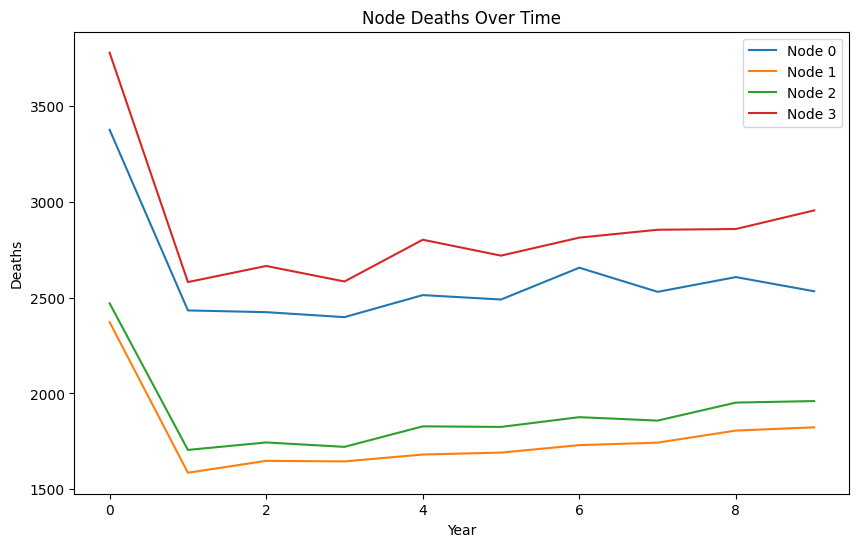

In [165]:
from matplotlib import pyplot as plt

node_deaths = model.nodes.deaths[nodes_to_plot, :]

plt.figure(figsize=(10, 6))
for i, node in enumerate(nodes_to_plot):
    plt.plot(range((model.params.ticks + 364) // 365), node_deaths[i, :], label=f"Node {node}")

plt.xlabel("Year")
plt.ylabel("Deaths")
plt.title("Node Deaths Over Time")
plt.legend()
plt.show()

## Cases Over Time

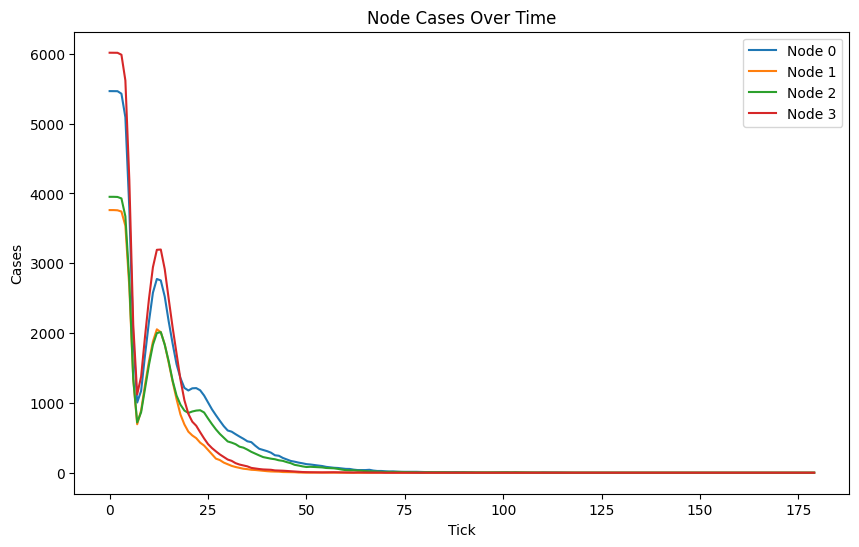

In [166]:
from matplotlib import pyplot as plt

group = 0
size = 16
nodes_to_plot = list(range(size*group,size*(group+1)))
nodes_to_plot = [ 0, 1, 2, 3 ]

window_start = 0
window_end = 180

plt.figure(figsize=(10, 6))
for i, node in enumerate(nodes_to_plot):
    plt.plot(range(window_start,window_end), model.nodes.cases[i, window_start:window_end], label=f"Node {node}")

plt.xlabel("Tick")
plt.ylabel("Cases")
plt.title("Node Cases Over Time")
plt.legend()
plt.show()

## Incidence Over Time

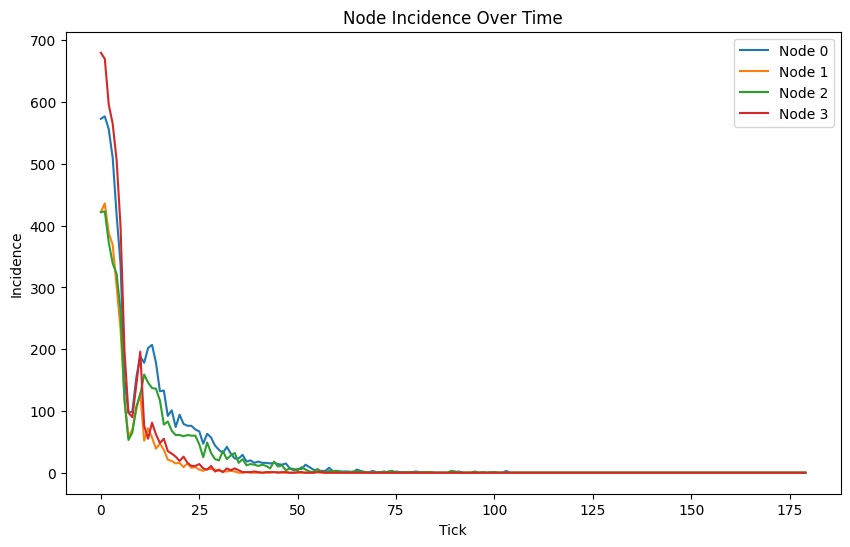

In [167]:
from matplotlib import pyplot as plt

group = 0
size = 16
nodes_to_plot = list(range(size*group,size*(group+1)))
nodes_to_plot = [ 0, 1, 2, 3 ]

window_start = 0
window_end = 180

plt.figure(figsize=(10, 6))
for i, node in enumerate(nodes_to_plot):
    plt.plot(range(window_start,window_end), model.nodes.incidence[i, window_start:window_end], label=f"Node {node}")

plt.xlabel("Tick")
plt.ylabel("Incidence")
plt.title("Node Incidence Over Time")
plt.legend()
plt.show()

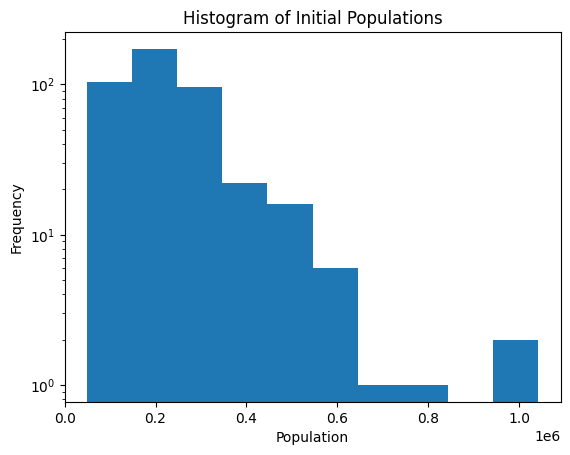

In [168]:
import matplotlib.pyplot as plt

plt.hist(initial_populations)
plt.xlabel('Population')
plt.ylabel('Frequency')
plt.title('Histogram of Initial Populations')
plt.yscale('log')  # Set y-axis to log scale
plt.show()

## Serosurvey Results (Checking the SIA)

In [169]:
# convert nodes 0-5 and ticks 5-15 of model.nodes.seronegativity to a DataFrame and print its rows

seronegativity = model.nodes.seronegativity[0:6, 0:16]
seronegativity_df = pd.DataFrame(seronegativity.transpose(), columns=[f"Node {i}" for i in range(6)])
print(seronegativity_df[5:16])
print()
print(np.array(seronegativity_df.iloc[11]) / np.array(seronegativity_df.iloc[9]))


    Node 0  Node 1  Node 2  Node 3  Node 4  Node 5
5        0       0       0       0       0       0
6        0       0       0       0       0       0
7        0       0       0       0       0       0
8        0       0       0       0       0       0
9     8756    6069    6267    9716   18140   11083
10       0       0       0       0       0       0
11    8438    1955    6017    3091   17484    3607
12       0       0       0       0       0       0
13       0       0       0       0       0       0
14       0       0       0       0       0       0
15       0       0       0       0       0       0

[0.96368205 0.32212885 0.9601085  0.31813503 0.96383682 0.3254534 ]


In [170]:
print(f"{model.nodes.ri_coverages[0:20]=}")
print(f"{model.population.dob[0:32]=}")
print(f"{model.population.dod[0:32]=}")
print(f"{model.nodes.seronegativity[0:6, 9:12].transpose()=}")
print(f"{model.nodes.cases[0:9,0:16].transpose()=}")
print(f"{model.nodes.births[0:9,0:16].transpose()=}")


model.nodes.ri_coverages[0:20]=array([0.47622274, 0.22036155, 0.98522527, 0.13700373, 0.97852928,
       0.16953883, 0.27912942, 0.21064626, 0.12834709, 0.92700596,
       0.71294196, 0.05859837, 0.62728704, 0.61403882, 0.40116459,
       0.09390595, 0.67710003, 0.0691091 , 0.99095782, 0.78455779])
model.population.dob[0:32]=array([-24793,  -8123, -17843, -13140, -17949, -21437,  -8676,  -6989,
        -3929, -16054, -34376,  -1522,  -7117,  -6713, -18982,  -8760,
       -22848, -21289, -10448, -11628, -23396,  -9423, -13282,  -8072,
       -16567,  -7584,  -9490, -19311, -19599,  -6041, -26381,  -6289],
      dtype=int32)
model.population.dod[0:32]=array([ 7431, 19252, 14639, 13184,  7013,  7952, 21086, 21649, 25906,
       17913,  1786, 23510, 28548, 11616, 16482, 14901, 10930,  9544,
       22143, 19628,  2659, 25155, 12796, 22069, 13828, 20078, 24615,
        4231,  3735, 18944,  6845, 16385], dtype=int32)
model.nodes.seronegativity[0:6, 9:12].transpose()=array([[ 8756,  6069,  626